# Markov Decision Process

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.


For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>


In [ ]:
transition_probs = {
    "s0": {"a0": {"s0": 0.5, "s2": 0.5}, "a1": {"s2": 1}},
    "s1": {"a0": {"s0": 0.7, "s1": 0.1, "s2": 0.2}, "a1": {"s1": 0.95, "s2": 0.05}},
    "s2": {"a0": {"s0": 0.4, "s2": 0.6}, "a1": {"s0": 0.3, "s1": 0.3, "s2": 0.4}},
}
rewards = {"s1": {"a0": {"s0": +5}}, "s2": {"a1": {"s0": -1}}}

from mdp import MDP

mdp = MDP(transition_probs, rewards, initial_state="s0")

We can now use MDP just as any other gym environment:


In [ ]:
print("initial state =", mdp.reset())
next_state, reward, done, info = mdp.step("a1")
print("next_state = %s, reward = %s, done = %s" % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration


In [ ]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions("s1"))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states("s1", "a0"))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward("s1", "a0", "s0"))
print(
    "mdp.get_transition_prob('s1', 'a0', 's0') = ",
    mdp.get_transition_prob("s1", "a0", "s0"),
)

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Visualizing MDPs

You have to install graphviz for system and for python.

1. - For ubuntu just run: `sudo apt-get install graphviz`
   - For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

**Note:** Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.


In [ ]:
from mdp import has_graphviz
from IPython.display import display

print("Graphviz available:", has_graphviz)

Graphviz available: False


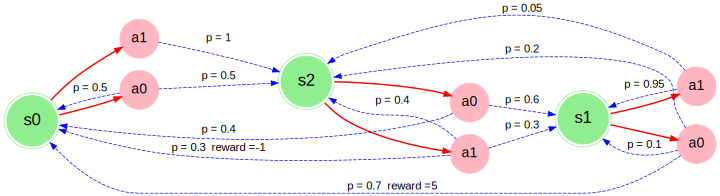

In [ ]:
if has_graphviz:
    from mdp import (
        plot_graph,
        plot_graph_with_state_values,
        plot_graph_optimal_strategy_and_state_values,
    )

    display(plot_graph(mdp))

# 1. Value Iteration (VI)

Now let's build something to solve this MDP. The simplest algorithm so far is **V**alue **I**teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$

`3.` $ \quad V*{(i+1)}(s) = \max_a \sum*{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---


First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [5]:
def get_action_value(mdp, state_values, state, action, gamma):
    """Computes Q(s,a) = ∑ P(s'|s,a) [r(s,a,s') + γ * V(s')]"""
    q_value = 0.0
    for next_state in mdp.get_next_states(state, action):
        prob = mdp.get_transition_prob(state, action, next_state)
        reward = mdp.get_reward(state, action, next_state)
        q_value += prob * (reward + gamma * state_values[next_state])
    return q_value


In [ ]:
import numpy as np

test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, "s2", "a1", 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, "s1", "a0", 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
$$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$


In [8]:
def get_new_state_value(mdp, state_values, state, gamma):
    """Computes V(s) = max_a Q(s,a)"""
    if mdp.is_terminal(state):
        return 0
    return max(
        get_action_value(mdp, state_values, state, action, gamma)
        for action in mdp.get_possible_actions(state)
    )


In [ ]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, "s0", 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, "s2", 0.9), 1.08)
assert np.isclose(
    get_new_state_value(mdp, {"s0": -1e10, "s1": 0, "s2": -2e10}, "s0", 0.9),
    -13500000000.0,
), "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, (
    "Please do not change state_values in get_new_state_value"
)

Finally, let's combine everything we wrote into a working value iteration algo.


In [ ]:
# parameters
gamma = 0.9  # discount for MDP
num_iter = 100  # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):
    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {
        s: get_new_state_value(mdp, state_values, s, gamma)
        for s in mdp.get_all_states()
    }

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print("   ".join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [ ]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [ ]:
print("Final state values:", state_values)

assert abs(state_values["s0"] - 3.781) < 0.01
assert abs(state_values["s1"] - 7.294) < 0.01
assert abs(state_values["s2"] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

$$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).


In [12]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """Finds optimal action using argmax over Q(s,a)"""
    if mdp.is_terminal(state):
        return None

    actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, a, gamma) for a in actions]
    best_action_index = np.argmax(q_values)
    return actions[best_action_index]


In [ ]:
assert get_optimal_action(mdp, state_values, "s0", gamma) == "a1"
assert get_optimal_action(mdp, state_values, "s1", gamma) == "a0"
assert get_optimal_action(mdp, state_values, "s2", gamma) == "a1"

assert (
    get_optimal_action(mdp, {"s0": -1e10, "s1": 0, "s2": -2e10}, "s0", 0.9) == "a0"
), "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert (
    get_optimal_action(mdp, {"s0": -2e10, "s1": 0, "s2": -1e10}, "s0", 0.9) == "a1"
), "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

In [ ]:
if has_graphviz:
    display(
        plot_graph_optimal_strategy_and_state_values(
            mdp, state_values, get_action_value
        )
    )

In [ ]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert 0.40 < np.mean(rewards) < 0.55

average reward:  0.4556


### Frozen lake


In [ ]:
from mdp import FrozenLakeEnv

mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [ ]:
def value_iteration(
    mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5
):
    """performs num_iter value iteration steps starting from state_values. Same as before but in a function"""
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):
        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {
            s: get_new_state_value(mdp, state_values, s, gamma)
            for s in mdp.get_all_states()
        }

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(
            abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states()
        )

        print(
            "iter %4i   |   diff: %6.5f   |   V(start): %.3f "
            % (i, diff, new_state_values[mdp._initial_state])
        )

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [17]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [ ]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end="\n\n")
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap="gray", interpolation="none", clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h) - 0.5)
    ax.set_yticks(np.arange(w) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {"left": (-1, 0), "down": (0, -1), "right": (1, 0), "up": (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(
                x,
                y,
                str(mdp.desc[y, x].item()),
                color="g",
                size=12,
                verticalalignment="center",
                horizontalalignment="center",
                fontweight="bold",
            )
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(
                x, y, u * 0.3, -v * 0.3, color="m", head_width=0.1, head_length=0.1
            )
    plt.grid(color="b", lw=2, ls="-")
    plt.show()

after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


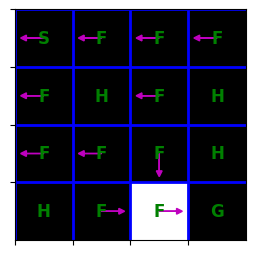

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


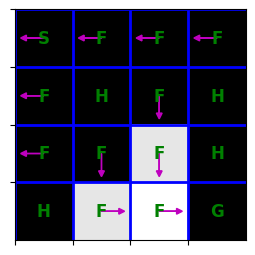

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


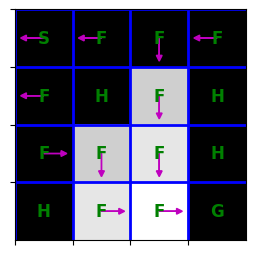

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


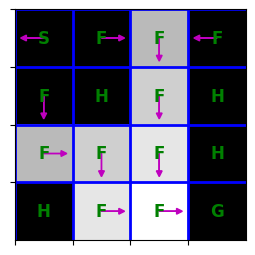

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


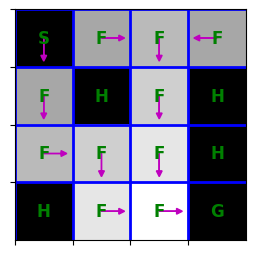

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


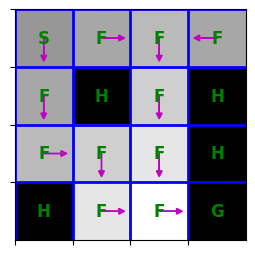

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 


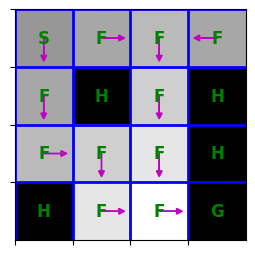

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 


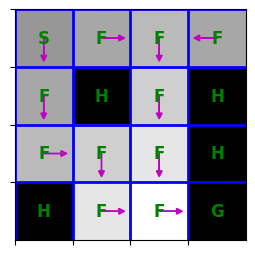

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 


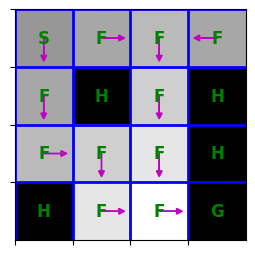

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 


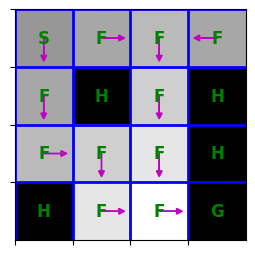

In [20]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


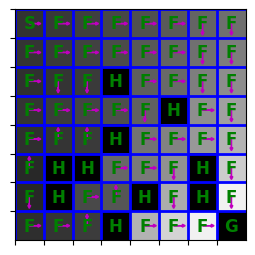

In [ ]:
from IPython.display import clear_output
from time import sleep

mdp = FrozenLakeEnv(map_name="8x8", slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests


In [ ]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert 1.0 <= np.mean(total_rewards) <= 1.0
print("Well done!")

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
average reward:  1.0
Well done!


In [ ]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert 0.8 <= np.mean(total_rewards) <= 0.95
print("Well done!")

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
average reward:  0.879
Well done!


In [ ]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert 0.6 <= np.mean(total_rewards) <= 0.7
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 

In [ ]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name="8x8")
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert 0.6 <= np.mean(total_rewards) <= 0.8
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

In [ ]:
transition_probs = {
    "s0": {"a0": {"s0": 0.6, "s1": 0.4}, "a1": {"s1": 1.0}},
    "s1": {"a0": {"s0": 0.3, "s2": 0.7}, "a1": {"s2": 1.0}},
    "s2": {
        "a0": {"s2": 1.0},
        "a1": {"s0": 0.5, "s2": 0.5},
    },
}

rewards = {
    "s0": {"a0": {"s0": 1, "s1": 2}, "a1": {"s1": 0}},
    "s1": {"a0": {"s0": -1, "s2": 4}, "a1": {"s2": 5}},
    "s2": {"a0": {"s2": 0}, "a1": {"s0": -2, "s2": 1}},
}

from mdp import MDP
from numpy import random

mdp = MDP(
    transition_probs,
    rewards,
    initial_state=random.choice(tuple(transition_probs.keys())),
)

In [ ]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array(
    [
        get_optimal_action(mdp, state_values, state, gamma)
        for state in sorted(mdp.get_all_states())
    ]
)

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array(
        [
            get_optimal_action(mdp, state_values, state, gamma)
            for state in sorted(mdp.get_all_states())
        ]
    )

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

after iteration 0
iter    0   |   diff: 5.00000   |   V(start): 0.000 
N actions changed = 2 

after iteration 1
iter    0   |   diff: 3.10000   |   V(start): 0.130 
N actions changed = 1 

after iteration 2
iter    0   |   diff: 1.45350   |   V(start): 1.583 
N actions changed = 0 

after iteration 3
iter    0   |   diff: 1.30815   |   V(start): 2.746 
N actions changed = 0 

after iteration 4
iter    0   |   diff: 1.04632   |   V(start): 3.563 
N actions changed = 0 

after iteration 5
iter    0   |   diff: 0.82120   |   V(start): 4.301 
N actions changed = 0 

after iteration 6
iter    0   |   diff: 0.70806   |   V(start): 5.002 
N actions changed = 0 

after iteration 7
iter    0   |   diff: 0.63435   |   V(start): 5.637 
N actions changed = 0 

after iteration 8
iter    0   |   diff: 0.57092   |   V(start): 6.202 
N actions changed = 0 

after iteration 9
iter    0   |   diff: 0.50950   |   V(start): 6.709 
N actions changed = 0 

after iteration 10
iter    0   |   diff: 0.45822  

### Value iteration convervence proof (1 pts)

**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

Update of value function in value iteration can be rewritten in a form of Bellman operator:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration algorithm with Bellman operator:

---

&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

In [lecture](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) we established contraction property of bellman operator:

$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

Using contraction property of Bellman operator, Banach fixed-point theorem and Bellman equations prove that value function converges to $V^*$ in value iterateion$

_<-- Your proof here -->_


### Asynchronious value iteration (2 pts)

Consider the following algorithm:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---

Note that unlike common value iteration, here we update only a single state at a time.

**Homework.** Prove the following proposition:

If for all $s \in \mathcal{S}$, $s$ appears in the sequence $(s_0, s_1, ...)$ infinitely often, then $V$ converges to $V*$

_<-- Your proof here -->_


# 2. Policy iteration

## Policy iteration implementateion

Let's implement exact policy iteration (PI), which has the following pseudocode:

---

Initialize $\pi_0$ `// random or fixed action`

For $n=0, 1, 2, \dots$

- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$

---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.

Below are a few helpers that you may or may not use in your implementation.


In [ ]:
transition_probs = {
    "s0": {"a0": {"s0": 0.5, "s2": 0.5}, "a1": {"s2": 1}},
    "s1": {"a0": {"s0": 0.7, "s1": 0.1, "s2": 0.2}, "a1": {"s1": 0.95, "s2": 0.05}},
    "s2": {"a0": {"s0": 0.4, "s1": 0.6}, "a1": {"s0": 0.3, "s1": 0.3, "s2": 0.4}},
}
rewards = {"s1": {"a0": {"s0": +5}}, "s2": {"a1": {"s0": -1}}}

from mdp import MDP

mdp = MDP(transition_probs, rewards, initial_state="s0")

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)


In [ ]:
import numpy as np


def compute_vpi(mdp, policy, gamma):
    states = mdp.get_all_states()
    n = len(states)
    state_idx = {s: i for i, s in enumerate(states)}

    P_pi = np.zeros((n, n))
    R_pi = np.zeros(n)

    for s in states:
        i = state_idx[s]
        a = policy[s]
        if a is None:
            P_pi[i, i] = 1.0
            R_pi[i] = 0.0
            continue
        for s_prime in mdp.get_next_states(s, a):
            j = state_idx[s_prime]
            prob = mdp.get_transition_prob(s, a, s_prime)
            reward = mdp.get_reward(s, a, s_prime)
            P_pi[i, j] += prob
            R_pi[i] += prob * reward

    A = np.eye(n) - gamma * P_pi
    V = np.linalg.solve(A, R_pi)

    return {s: V[state_idx[s]] for s in states}


In [36]:
test_policy = {
    s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()
}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(new_vpi) is dict, (
    "compute_vpi must return a dict {state : V^pi(state) for all states}"
)

{'s0': np.float64(3.789948615114679), 's1': np.float64(7.3029201654342675), 's2': np.float64(4.211054016794088)}


Once we've got new state values, it's time to update our policy.


In [37]:
def compute_new_policy(mdp, vpi, gamma):
    new_policy = {}
    for s in mdp.get_all_states():
        if mdp.is_terminal(s):
            new_policy[s] = None
            continue
        actions = mdp.get_possible_actions(s)
        q_values = []
        for a in actions:
            q = 0
            for s_prime in mdp.get_next_states(s, a):
                prob = mdp.get_transition_prob(s, a, s_prime)
                reward = mdp.get_reward(s, a, s_prime)
                q += prob * (reward + gamma * vpi[s_prime])
            q_values.append(q)
        best_action = actions[np.argmax(q_values)]
        new_policy[s] = best_action
    return new_policy


In [38]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(new_policy) is dict, (
    "compute_new_policy must return a dict {state : optimal action for all states}"
)

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


In [39]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    states = mdp.get_all_states()

    if policy is None:
        policy = {
            s: (
                None
                if mdp.is_terminal(s)
                else np.random.choice(mdp.get_possible_actions(s))
            )
            for s in states
        }

    for i in range(num_iter):
        vpi = compute_vpi(mdp, policy, gamma)

        new_policy = compute_new_policy(mdp, vpi, gamma)

        if all(policy[s] == new_policy[s] for s in states):
            print(f"Policy iteration converged at iteration {i}")
            break

        policy = new_policy

    return vpi, policy


**Your PI Results**


In [40]:
from mdp import FrozenLakeEnv

gamma = 0.9

# 1. PI - small FrozenLake
mdp_small = FrozenLakeEnv(slip_chance=0, map_name="4x4")
vpi_small, policy_small = policy_iteration(mdp_small, gamma=gamma)
print("Policy Iteration (4x4) state values:", vpi_small)

# 2. VI - small FrozenLake
state_values_vi = value_iteration(mdp_small, gamma=gamma)
print("Value Iteration (4x4) state values:", state_values_vi)

# 3. PI - large FrozenLake
mdp_large = FrozenLakeEnv(slip_chance=0, map_name="8x8")
vpi_large, policy_large = policy_iteration(mdp_large, gamma=gamma)
print("Policy Iteration (8x8) state values:", vpi_large)

# 4. VI - large FrozenLake
state_values_vi_large = value_iteration(mdp_large, gamma=gamma)
print("Value Iteration (8x8) state values:", state_values_vi_large)


Policy iteration converged at iteration 6
Policy Iteration (4x4) state values: {(0, 0): np.float64(0.5904900000000002), (0, 1): np.float64(0.6561000000000001), (0, 2): np.float64(0.7290000000000001), (0, 3): np.float64(0.6561000000000001), (1, 0): np.float64(0.6561000000000001), (1, 1): np.float64(0.0), (1, 2): np.float64(0.81), (1, 3): np.float64(0.0), (2, 0): np.float64(0.7290000000000001), (2, 1): np.float64(0.81), (2, 2): np.float64(0.9), (2, 3): np.float64(0.0), (3, 0): np.float64(0.0), (3, 1): np.float64(0.9), (3, 2): np.float64(1.0), (3, 3): np.float64(0.0)}
iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
Value Iteration (4x4) state values: {(0, 0): 0.5904900000